# [DACON] 건설기계 오일 상태 분류 AI 경진대회
### 배경
- 건설기계 분야의 데이터를 분석, 활용하는 방안 제시
- 건설 장비 산업의 지능화에 대한 연구활동 홍보 및 우수 인재 발굴

### 주제
- 건설장비에서 작동 오일의 상태를 실시간으로 모니터링하기 위한 **오일 상태 판단 모델 개발**
- 적절한 교체 주기를 파악하고자 함

### 평가방식
- Macro F1 Score

### Library

In [2]:
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import random

import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# import pycaret.classification as pycaret_clf

import warnings
warnings.filterwarnings("ignore")

### Data Load

In [2]:
main_path = "./data"

train_df = pd.read_csv(os.path.join(main_path, "train.csv"))
test_df = pd.read_csv(os.path.join(main_path, "test.csv"))

train_df.shape, test_df.shape

((14095, 54), (6041, 19))

In [4]:
# 실제 진단 환경(Inference)에 사용되는 컬럼
test_stage_features = ['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR' , 'ANONYMOUS_2', 'AG', 'CO', 'CR', 'CU', 'FE', 'H2O', 'MN', 'MO', 'NI', 'PQINDEX', 'TI', 'V', 'V40', 'ZN']
test_stage_features.append("Y_LABEL")
len(test_stage_features)

19

In [5]:
train_df = train_df[test_stage_features]
train_df.shape

(14095, 19)

In [6]:
set(train_df.columns.tolist()) - set(test_df.columns.tolist()), set(test_df.columns.tolist()) - set(train_df.columns.tolist())

({'Y_LABEL'}, {'ID'})

In [7]:
# Test 데이터에서 필요없는 부분 제거
test_df = test_df.drop(columns="ID", axis=1)
test_df.shape

(6041, 18)

In [8]:
display(train_df.head())
display(test_df.head())

,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN,Y_LABEL
0,COMPONENT3,1486,2011,200,0,0,13,78,888,0.0,16,1,6,8504,5,0,154.0,75,0
1,COMPONENT2,1350,2021,375,0,0,0,31,2,0.0,0,0,0,19,0,0,44.0,652,0
2,COMPONENT2,2415,2015,200,0,0,1,2,4,0.0,0,0,0,17,0,0,72.6,412,1
3,COMPONENT3,7389,2010,200,0,0,0,1,37,0.0,1,0,0,44,0,0,133.3,7,0
4,COMPONENT3,3954,2015,200,0,0,0,0,71,0.0,0,0,0,217,0,0,133.1,128,0


,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,ANONYMOUS_2,AG,CO,CR,CU,FE,H2O,MN,MO,NI,PQINDEX,TI,V,V40,ZN
0,COMPONENT1,2192,2016,200,0,0,0,1,12,0.0,0,0,0,10,0,0,91.3,1091
1,COMPONENT3,2794,2011,200,0,0,2,1,278,0.0,3,0,0,2732,1,0,126.9,12
2,COMPONENT2,1982,2010,200,0,0,0,16,5,0.0,0,0,0,11,0,0,44.3,714
3,COMPONENT3,1404,2009,200,0,0,3,4,163,0.0,4,3,0,8007,0,0,142.8,94
4,COMPONENT2,8225,2013,200,0,0,0,6,13,0.0,0,0,0,16,0,0,63.4,469


### EDA
#### 결측치 확인

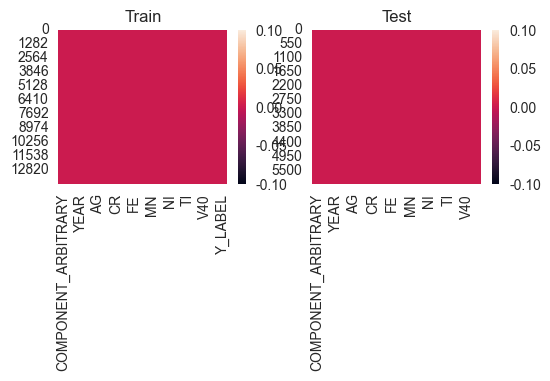

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(6, 2))
sns.heatmap(train_df.isnull(), ax=ax[0]).set_title("Train")
sns.heatmap(test_df.isnull(), ax=ax[1]).set_title("Test")
plt.show()

#### 데이터 타입 확인

In [23]:
train_df.dtypes

COMPONENT_ARBITRARY     object
ANONYMOUS_1              int64
YEAR                     int64
ANONYMOUS_2              int64
AG                       int64
CO                       int64
CR                       int64
CU                       int64
FE                       int64
H2O                    float64
MN                       int64
MO                       int64
NI                       int64
PQINDEX                  int64
TI                       int64
V                        int64
V40                    float64
ZN                       int64
Y_LABEL                  int64
dtype: object

#### 이상치 확인

In [30]:
numeric_cols = train_df.columns.tolist()
numeric_cols.remove("COMPONENT_ARBITRARY")
numeric_cols.remove("Y_LABEL")

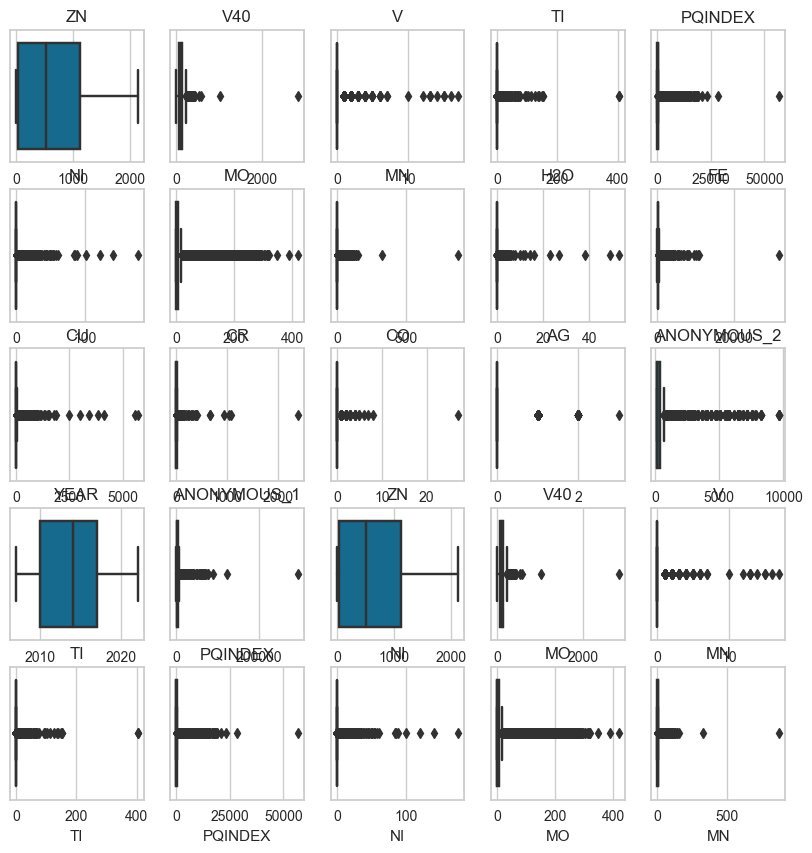

In [81]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
idx = len(numeric_cols)-1
for r_idx in range(axes.shape[0]):
    for c_idx in range(axes.shape[1]):
        sns.boxplot(data=train_df, x=numeric_cols[idx], ax=axes[r_idx][c_idx]).set_title(f"{numeric_cols[idx]}")
        idx -= 1

대부분의 값들이 이상치가 많음  
-> 이상치 제거시 데이터 부족

#### 분포

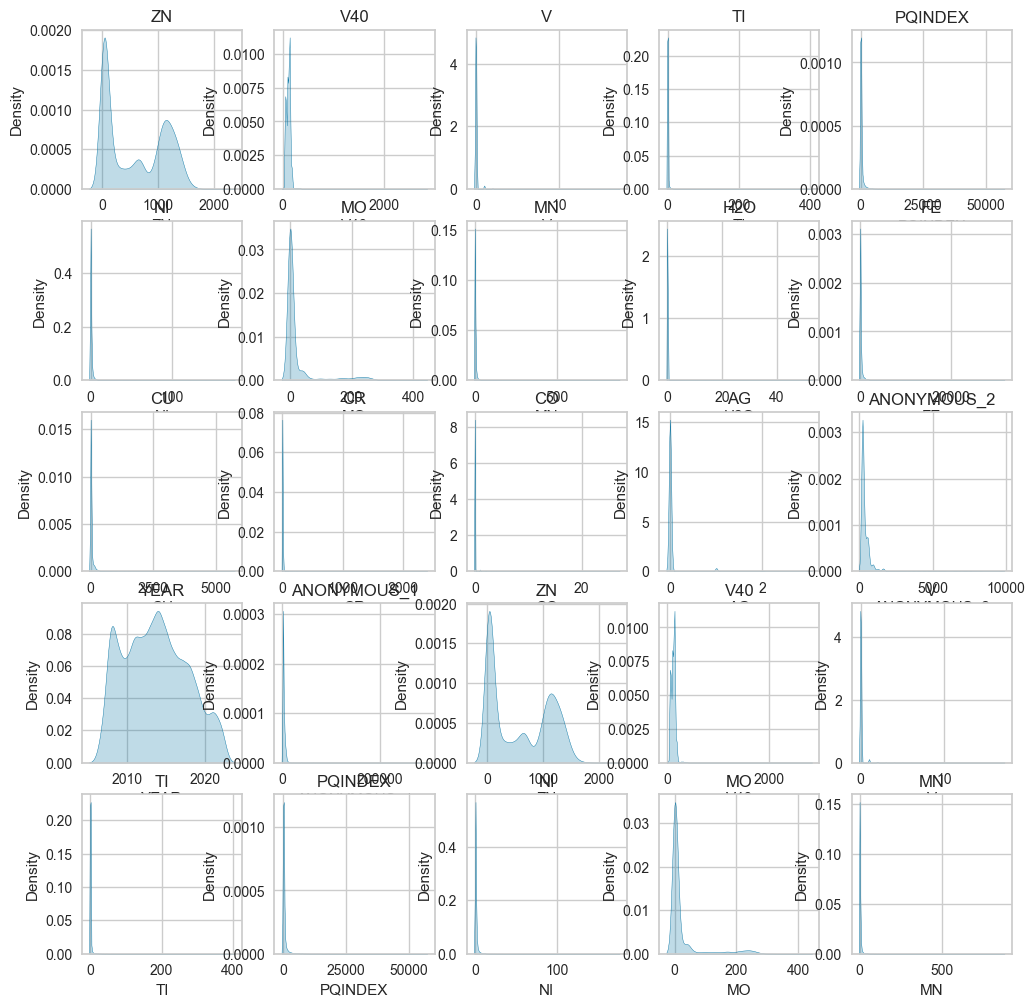

In [84]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
idx = len(numeric_cols)-1
for r_idx in range(axes.shape[0]):
    for c_idx in range(axes.shape[1]):
        sns.kdeplot(data=train_df, x=numeric_cols[idx], shade=True, ax=axes[r_idx][c_idx]).set_title(f"{numeric_cols[idx]}")
        idx -= 1

In [98]:
# 스케일링
for col in numeric_cols:
    robust_scaler = RobustScaler()
    robust_scaler.fit(train_df[col].values.reshape(-1, 1))
    train_df[col] = (robust_scaler.transform(train_df[col].values.reshape(-1, 1))).reshape(-1)
    test_df[col] = (robust_scaler.transform(test_df[col].values.reshape(-1, 1))).reshape(-1)

#### 정답 비율

In [101]:
train_df["Y_LABEL"].value_counts(normalize=True)

0    0.914651
1    0.085349
Name: Y_LABEL, dtype: float64

#### SMOTE 오버 샘플링 적용

In [114]:
train_df = pd.get_dummies(data=train_df, columns=["COMPONENT_ARBITRARY"])
test_df = pd.get_dummies(data=test_df, columns=["COMPONENT_ARBITRARY"])

In [121]:
features = train_df.columns.tolist()
features.remove("Y_LABEL")

In [123]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

x_train, y_train = smote.fit_sample(train_df[features], train_df["Y_LABEL"])

In [126]:
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: Y_LABEL, dtype: float64

In [131]:
oversampling_df = pd.concat([x_train, y_train], axis=1)

### PyCaret

In [132]:
setup_clf = pycaret_clf.setup(session_id=42, data=oversampling_df, target="Y_LABEL", normalize=True, transformation=True, use_gpu=True)

,Description,Value
0,session_id,42
1,Target,Y_LABEL
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(25784, 22)"
5,Missing Values,False
6,Numeric Features,21
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [136]:
top3 = pycaret_clf.compare_models(sort="F1", n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9588,0.9912,0.9622,0.9560,0.9590,0.9177,0.9177,1.0540
rf,Random Forest Classifier,0.9490,0.9868,0.9319,0.9652,0.9482,0.8981,0.8987,0.8640
lightgbm,Light Gradient Boosting Machine,0.9450,0.9737,0.8972,0.9923,0.9423,0.8900,0.8941,1.5050
gbc,Gradient Boosting Classifier,0.9008,0.9551,0.8392,0.9577,0.8945,0.8017,0.8080,3.6990
dt,Decision Tree Classifier,0.8851,0.8851,0.8995,0.8749,0.8870,0.7703,0.7707,0.1620
knn,K Neighbors Classifier,0.8233,0.9166,0.9499,0.7586,0.8435,0.6463,0.6682,0.8560
ada,Ada Boost Classifier,0.7792,0.8660,0.7837,0.7775,0.7805,0.5584,0.5586,0.9000
dummy,Dummy Classifier,0.5011,0.5000,1.0000,0.5011,0.6677,0.0000,0.0000,0.0110
ridge,Ridge Classifier,0.6582,0.0000,0.6576,0.6595,0.6585,0.3165,0.3165,0.0230
lda,Linear Discriminant Analysis,0.6583,0.7075,0.6575,0.6596,0.6585,0.3166,0.3166,0.0550


In [137]:
tuned3 = [pycaret_clf.tune_model(model, n_iter=15) for model in top3]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9590,0.9787,0.9248,0.9929,0.9576,0.9180,0.9202
1,0.9468,0.9731,0.9038,0.9891,0.9445,0.8936,0.8970
2,0.9446,0.9721,0.9027,0.9855,0.9423,0.8892,0.8924
3,0.9424,0.9724,0.8993,0.9843,0.9399,0.8848,0.8881
4,0.9479,0.9730,0.9039,0.9915,0.9457,0.8959,0.8994
5,0.9485,0.9790,0.9072,0.9892,0.9464,0.8970,0.9001
6,0.9468,0.9765,0.8961,0.9975,0.9441,0.8937,0.8983
7,0.9440,0.9737,0.9028,0.9843,0.9418,0.8881,0.8912
8,0.9490,0.9770,0.9082,0.9892,0.9469,0.8980,0.9011


In [138]:
blender = pycaret_clf.blend_models(estimator_list=tuned3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9463,0.9786,0.9281,0.9633,0.9454,0.8925,0.8931
1,0.9280,0.9733,0.9049,0.9490,0.9264,0.8560,0.8569
2,0.9324,0.9719,0.9049,0.9578,0.9306,0.8648,0.8662
3,0.9391,0.9688,0.9148,0.9616,0.9376,0.8781,0.8792
4,0.9341,0.9717,0.9072,0.9591,0.9324,0.8682,0.8694
5,0.9407,0.9746,0.9171,0.9629,0.9394,0.8815,0.8825
6,0.9407,0.9774,0.9061,0.9739,0.9388,0.8815,0.8836
7,0.9302,0.9702,0.9028,0.9556,0.9284,0.8604,0.8617
8,0.9368,0.9783,0.9159,0.9561,0.9356,0.8736,0.8744


In [ ]:
final_model = pycaret_clf.finalize_model(blender)

In [140]:
pred = pycaret_clf.predict_model(final_model, data=test_df)

In [142]:
sub = pd.read_csv("./data/sample_submission.csv")
sub["Y_LABEL"] = pred["Label"]

In [143]:
sub.to_csv("./pycaret_tuned3.csv", index=False)

### 단일 생성 -> 블랜드
lgbm은 튜닝시 성능이 좋아지지만, xtc와 rf는 튜닝시 성능이 떨어지는 문제점 발견

In [145]:
clf_et = pycaret_clf.create_model("et")
clf_rf = pycaret_clf.create_model("rf")
clf_lgbm = pycaret_clf.create_model("lightgbm")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9596,0.9781,0.9215,0.9976,0.9580,0.9191,0.9218
1,0.9418,0.9739,0.8949,0.9878,0.9391,0.8837,0.8876
2,0.9446,0.9708,0.8949,0.9939,0.9418,0.8892,0.8937
3,0.9418,0.9729,0.8916,0.9914,0.9388,0.8837,0.8882
4,0.9463,0.9729,0.9006,0.9915,0.9438,0.8925,0.8963
5,0.9446,0.9762,0.8983,0.9903,0.9421,0.8892,0.8931
6,0.9407,0.9779,0.8873,0.9938,0.9375,0.8815,0.8866
7,0.9440,0.9727,0.8961,0.9914,0.9414,0.8881,0.8923
8,0.9496,0.9777,0.9038,0.9951,0.9472,0.8991,0.9030


In [146]:
clf_lgbm = pycaret_clf.tune_model(clf_lgbm, n_iter=15)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9590,0.9787,0.9248,0.9929,0.9576,0.9180,0.9202
1,0.9457,0.9733,0.9015,0.9891,0.9433,0.8914,0.8950
2,0.9440,0.9720,0.9027,0.9843,0.9417,0.8881,0.8912
3,0.9440,0.9731,0.9004,0.9867,0.9416,0.8881,0.8915
4,0.9474,0.9720,0.9083,0.9856,0.9454,0.8948,0.8975
5,0.9463,0.9785,0.9072,0.9844,0.9442,0.8925,0.8953
6,0.9468,0.9765,0.8961,0.9975,0.9441,0.8937,0.8983
7,0.9435,0.9736,0.9028,0.9832,0.9412,0.8870,0.8900
8,0.9490,0.9770,0.9082,0.9892,0.9469,0.8980,0.9011


In [147]:
blender = pycaret_clf.blend_models(estimator_list=[clf_et, clf_rf, clf_lgbm])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9751,0.9965,0.9679,0.9820,0.9749,0.9501,0.9502
1,0.9596,0.9926,0.9369,0.9815,0.9587,0.9191,0.9201
2,0.9618,0.9914,0.9392,0.9838,0.9610,0.9236,0.9245
3,0.9657,0.9917,0.9447,0.9861,0.9650,0.9313,0.9321
4,0.9634,0.9950,0.9459,0.9805,0.9629,0.9269,0.9275
5,0.9640,0.9935,0.9503,0.9773,0.9636,0.9280,0.9283
6,0.9706,0.9947,0.9470,0.9942,0.9700,0.9413,0.9424
7,0.9612,0.9936,0.9481,0.9739,0.9608,0.9224,0.9228
8,0.9684,0.9951,0.9558,0.9807,0.9681,0.9368,0.9371


In [ ]:
final_model = pycaret_clf.finalize_model(blender)

In [149]:
pred = pycaret_clf.predict_model(final_model, data=test_df)

In [150]:
sub = pd.read_csv("./data/sample_submission.csv")
sub["Y_LABEL"] = pred["Label"]
sub.to_csv("./pycaret_only_tune_lgbm.csv", index=False)

### CatBoost
이전 단일 테스트 중, 가장 성능이 좋았던 CatBoost

In [151]:
from catboost import CatBoostClassifier

In [152]:
clf_CAT = CatBoostClassifier(iterations=100, random_state=42)

In [ ]:
clf_CAT.fit(oversampling_df[features], oversampling_df["Y_LABEL"])

In [157]:
cpred = clf_CAT.predict(test_df)

In [159]:
sub = pd.read_csv("./data/sample_submission.csv")
sub["Y_LABEL"] = cpred
sub.to_csv("./CAT_after_EDA.csv", index=False)